# Sentiment Analysis in Python

In this notebook we will be doing some sentiment analysis in python using two different techniques:

- VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
- Roberta Pretrained Model from 🤗
- Huggingface Pipeline

## Step 0. Read in Data and NLTK Basics

In [1]:
!pip install nltk

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/jovyan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
#read data
df=pd.read_csv("amazon-fine-food-reviews/Reviews.csv",nrows=500)  #reading only first few rows for speed

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Here Score is in scale of 0-5 stars and text is user review.

### Quick EDA

<AxesSubplot: title={'center': 'Count of reviews by stars'}, xlabel='Review Stars'>

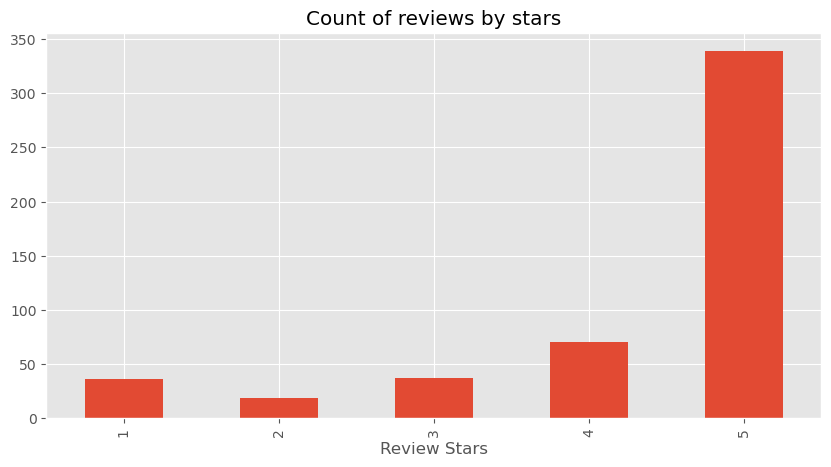

In [5]:
df['Score'].value_counts().sort_index().plot(kind='bar',title='Count of reviews by stars',figsize=(10,5),xlabel="Review Stars")

### Basic NLTK

In [6]:
example=df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
tokens=nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [8]:
#this tags each word with appropriate parts of speech, you can search their full form on internet
tagged=nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [9]:
entities=nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1. VADER Seniment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text. This scoring does not take order of words in consideration.

This uses a "bag of words" approach:
- Stop words are removed (is,and,the,etc)
- each word is scored and combined to a total score.

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia=SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores("i am very very happy")

{'neg': 0.0, 'neu': 0.413, 'pos': 0.587, 'compound': 0.6453}

In [12]:
#run polarity_scores for entire dataset
pol_score={}
for i,rows in tqdm(df.iterrows(),total=len(df)):
    pol_score[rows['Id']]=sia.polarity_scores(rows['Text'])

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
vaders=pd.DataFrame(pol_score).T
vaders=vaders.reset_index().rename(columns={'index':'Id'})
vaders=vaders.merge(df,how='left',on='Id')
vaders.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


### Plot vader results

Text(0.5, 1.0, 'Compound score by amazon')

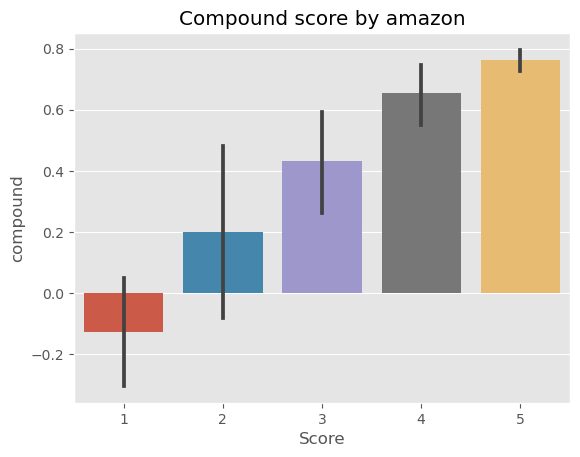

In [14]:
ax=sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title('Compound score by amazon')

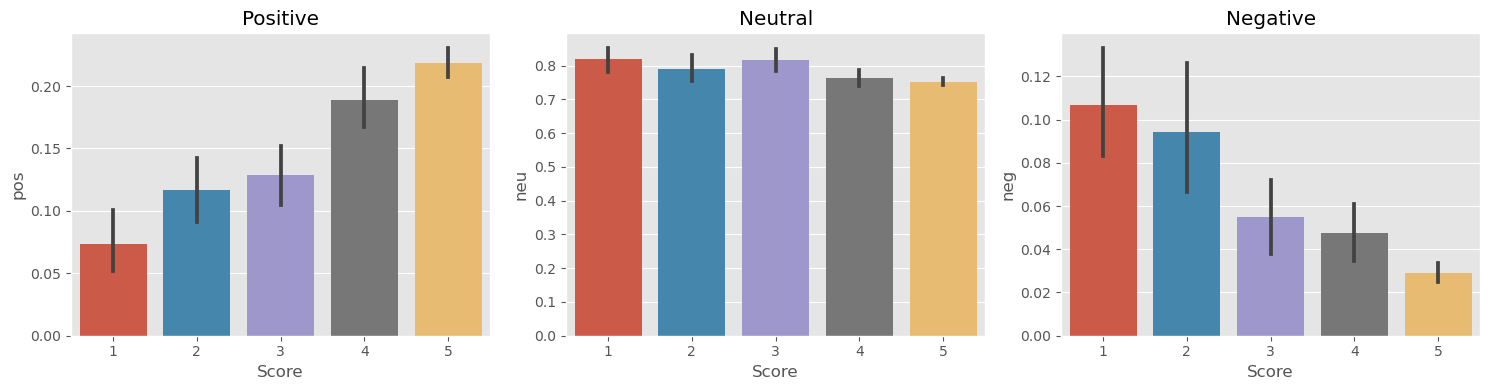

In [15]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
sns.barplot(data=vaders,x='Score',y='pos',ax=ax[0])
sns.barplot(data=vaders,x='Score',y='neu',ax=ax[1])
sns.barplot(data=vaders,x='Score',y='neg',ax=ax[2])
ax[0].set_title('Positive')
ax[1].set_title('Neutral')
ax[2].set_title('Negative')
plt.tight_layout()

## Step 3. Roberta Pretrained Model
- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [16]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from scipy.special import softmax

In [17]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
#VADER results
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [32]:
#Roberta model
encoded_text=tokenizer(example,return_tensors='pt')
output=model(**encoded_text)
scores=output[0][0].detach().numpy()
scores=softmax(scores)
scores_dict={'roberta_neg':scores[0],'roberta_neu':scores[1],'roberta_pos':scores[2]}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [33]:
def polarity_scores_roberta(example):
    encoded_text=tokenizer(example,return_tensors='pt')
    output=model(**encoded_text)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={'roberta_neg':scores[0],'roberta_neu':scores[1],'roberta_pos':scores[2]}
    return scores_dict

In [39]:
res={}
for i,rows in tqdm(df.iterrows(),total=len(df)):
    try:
        pol_score=sia.polarity_scores(rows['Text'])
        vader_results={}
        for key,val in pol_score.items():
            vader_results[f"vader_{key}"]=val

        roberta_results=polarity_scores_roberta(rows['Text'])
        combined_res={**vader_results,**roberta_results} #This line combines 2 dictionary
        res[rows['Id']]=combined_res
    except RuntimeError:
        print("Error on Id:",rows['Id'])

  0%|          | 0/500 [00:00<?, ?it/s]

Error on Id: 83
Error on Id: 187


In [40]:
results_df=pd.DataFrame(res).T
results_df=results_df.reset_index().rename(columns={'index':'Id'})
results_df=results_df.merge(df,how='left',on='Id')
results_df.head(3)


,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Step 4: Review Examples:
- Positive 1-Star and Negative 5-Star Reviews
- Lets look at some examples where the roberta model has given high positive score but actual score by user is 1.

In [48]:
results_df.query('Score == 1').sort_values('roberta_pos',ascending=False).head(3)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
252,255,0.091,0.736,0.172,0.4118,0.059614,0.314749,0.625637,B0048IC328,A1W867A8DSHFHC,no name,1,3,1,1339804800,Don't Waste Your Money,"I felt energized within five minutes, but it l..."
206,209,0.050,0.820,0.130,0.8913,0.095904,0.282240,0.621856,B0028C44Z0,A3BJ9NS09YGQT5,"Atl Chris ""Atl Chris""",0,3,1,1314489600,These just don't do it for me as breath mints,"To me, these are nothing like the regular Alto..."
322,325,0.213,0.514,0.274,0.3185,0.081018,0.311803,0.607179,B000JEHAHS,A2CU16YU1KEOUY,"Hurricane Ridge ""Chris""",5,19,1,1168300800,Never Arrived,So we cancelled the order. It was cancelled w...


In [52]:
results_df.query('Score == 1').sort_values('roberta_pos',ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

Lets look at some examples where the vader model has given high positive score but actual score by user is 1.

In [53]:
results_df.query('Score == 1').sort_values('vader_pos',ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [54]:
#negative sentiment 5 star review, vader model
results_df.query('Score == 5').sort_values('vader_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [55]:
#negative sentiment 5 star review, roberta model
results_df.query('Score == 5').sort_values('roberta_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## The Transformers Pipeline
- Quick and easy way to run sentiment predictions

In [56]:
from transformers import pipeline

sent_pipeline=pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [60]:
sent_pipeline('I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money')

[{'label': 'NEGATIVE', 'score': 0.9971690773963928}]

In [61]:
sent_pipeline('So we cancelled the order.  It was cancelled without any problem.  That is a positive note...')

[{'label': 'POSITIVE', 'score': 0.9988051652908325}]